In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import igraph as ig
import gravis as gv
import networkx as nx
#import leidenalg as la

from matplotlib import rc
from functions import clean_address, es_diagonal_cero, propiedades, centralidades, centralizacion

In [2]:
dfa = pd.read_excel("../Datasets/Research_status_2017_2022.xlsx")

In [3]:
top = ['Multidisciplinary', 'Particles & Fields', 'Applied', 'Condensed Matter', 'Mathematical', 'Molecular & Chemical', 'Physical', 'Astronomy & Astrophysics', 'Fluids & Plasmas']
anios = [2017, 2018, 2019, 2020, 2021, 2022]

## Todos los años

In [4]:
dfe = dfa.copy()
dfe = dfe[['Language', 'Affiliations', 'Document Type', 'Addresses', 'Publication Year', 'WoS Categories']]
dfe = dfe.dropna(subset = ['Addresses', 'Affiliations'])
dfe = dfe[dfe['Document Type']=='Article']
dfe = dfe[dfe['Publication Year']<2023]
dfe["Addresses"] = dfe["Addresses"].apply(lambda x: re.sub(r'\[.*?\]', '', x))
dfe['Addresses'] = dfe['Addresses'].apply(lambda x: x + ';')
dfe['Countries'] = dfe['Addresses'].apply(lambda x: '; '.join(re.findall(r', ([A-Z][a-z]+);', x)))
pattern = re.compile(r'USA|Peoples R China|BELARUS|Korea|Czech Republic|U Arab Emirates|South Africa|Ireland')

dfe = dfe[~dfe['Addresses'].str.contains(r', [A-Z][a-z]+ [A-Z][a-z]+;', regex=True)]
dfe = dfe[~dfe['Addresses'].str.contains(pattern)]
dfe['Paises'] = dfe['Countries'].apply(clean_address)
dfe['Categorias'] = dfe['WoS Categories'].apply(clean_address)
dfe['Type'] = dfe['Document Type'].apply(clean_address)

dfe = dfe[dfe['Categorias'].apply(lambda x: all(item in top for item in x))]
dfe = dfe[dfe['Paises'].apply(lambda x: len(x) == 1 and x[0] == 'Brazil')]


In [5]:
dfAll = dfe
dfAll['Instituciones'] = dfAll['Affiliations'].str.split(';', expand=False)
dfAll['Instituciones'] = dfAll['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfAll['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfAll['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adjAll = adj_matrix.to_numpy()
adjAll = adjAll.astype(float)

InstA = nx.Graph()

for countries in dfAll['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                InstA.add_edge(countries[i], countries[j], weight=adjAll[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(InstA)
nx.set_node_attributes(InstA, c, 'betweenness')


fig = gv.d3(InstA, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

print(len(all_inst))

198


In [6]:
print(propiedades(InstA))

Graph with 193 nodes and 1514 edges
N de Nodos:  193
N de aristas:  1514
Es direccionado:  False
Transitividad 0.3605288434374823
Centralización  0.0024480814154304834
Tiene:  7 comunidades
[frozenset({'Universidade Estadual Vale do Acarau', 'Universidade Estadual do Piaui (UESPI)', 'Empresa Brasileira de Pesquisa Agropecuaria (EMBRAPA)', 'Universidade Estadual de Santa Cruz', 'Universidade Federal do Cariri', 'Instituto Federal do Maranhao', 'Universidade Federal de Ouro Preto', 'Universidade do Estado do Rio Grande do Norte (UERN)', 'Universidade do Estado de Minas Gerais', 'Universidade Federal de Pernambuco', 'Instituto Federal de Sergipe (IFS)', 'Universidade Fortaleza', 'Universidade Federal da Paraiba', 'Universidade Federal do Tocantins (UFT)', 'Instituto Federal do Para', 'Universidade Estadual do Ceara', 'Universidade do Estado do Para (UEPA)', 'Universidade Federal de Alagoas', 'Instituto Federal do Rio Grande do Norte', 'Instituto Federal da Paraiba (IFPB)', 'Universidade F

### 2017

In [7]:
dfe2017 = dfe[dfe['Publication Year']==2017].copy()
dfe2017['Instituciones'] = dfe2017['Affiliations'].str.split(';', expand=False)
dfe2017['Instituciones'] = dfe2017['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2017['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2017['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2017 = nx.Graph()

for countries in dfe2017['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            graph2017.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])



c = nx.algorithms.degree_centrality(graph2017)
nx.set_node_attributes(graph2017, c, 'betweenness')


labels = {node: node for node in graph2017.nodes()}
fig = gv.d3(graph2017, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2017 = centralidades(graph2017)
cent_grado = centr2017['centralidad'].head(20)
centralizacion2017 = centralizacion(graph2017)
densidad2017 = nx.density(graph2017)
asort2017 = nx.degree_assortativity_coefficient(graph2017)
trans2017 = nx.transitivity(graph2017)

In [8]:
print(propiedades(graph2017))

Graph with 139 nodes and 549 edges
N de Nodos:  139
N de aristas:  549
Es direccionado:  False
Transitividad 0.2670657157412124
Centralización  0.0021897043649972353
Tiene:  7 comunidades
[frozenset({'Instituto Federal de Educacao, Ciencia e Tecnologia de Minas Gerais (IFMG)', 'Universidade Estadual do Norte Fluminense', 'Universidade Estadual de Campinas', 'Universidade Estadual do Sudoeste da Bahia', 'Universidade do Estado do Amazonas', 'Laboratorio Nacional de Computacao Cientifica (LNCC)', 'Centro Universitario da FEI', 'Universidade Estadual do Centro Oeste', 'Universidade Cruzeiro do Sul', 'Universidade Tiradentes', 'Universidade de Caxias do Sul', 'Universidade do Estado de Santa Catarina', 'Centro Universitario Central Paulista', 'Universidade Federal da Fronteira Sul', 'Universidade Estadual de Londrina', 'Instituto Federal do Parana', 'Universidade Federal do Parana', 'Universidade Catolica de Brasilia', 'Instituto Federal da Bahia (IFBA)', 'Universidade Catolica Dom Bosco (

### 2018

In [9]:
dfe2018 = dfe[dfe['Publication Year']==2018].copy()
dfe2018['Instituciones'] = dfe2018['Affiliations'].str.split(';', expand=False)
dfe2018['Instituciones'] = dfe2018['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2018['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2018['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2018 = nx.Graph()

for countries in dfe2018['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2018.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2018)
nx.set_node_attributes(graph2018, c, 'betweenness')


labels = {node: node for node in graph2018.nodes()}
fig = gv.d3(graph2018, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2018 = centralidades(graph2018)
cent_grado = centr2018['centralidad'].head(20)
centralizacion2018 = centralizacion(graph2018)
densidad2018 = nx.density(graph2018)
asort2018 = nx.degree_assortativity_coefficient(graph2018)
trans2018 = nx.transitivity(graph2018)

In [10]:
print(propiedades(graph2018))

Graph with 123 nodes and 440 edges
N de Nodos:  123
N de aristas:  440
Es direccionado:  False
Transitividad 0.3019261637239165
Centralización  0.002106649549907714
Tiene:  10 comunidades
[frozenset({'Universidade Estadual do Piaui (UESPI)', 'Instituto Federal do Maranhao', 'Universidade do Estado do Rio Grande do Norte (UERN)', 'Universidade Cruzeiro do Sul', 'Universidade do Estado de Santa Catarina', 'Universidade Federal de Pernambuco', 'Universidade Fortaleza', 'Universidade Federal da Paraiba', 'Universidade Estadual do Ceara', 'Universidade Federal de Alagoas', 'Instituto Federal do Rio Grande do Norte', 'Instituto Federal da Paraiba (IFPB)', 'Universidade Federal de Campina Grande', 'Universidade Federal Rural do Semi-Arido (UFERSA)', 'Universidade Federal do Triangulo Mineiro', 'Universidade Federal de Lavras', 'Instituto Federal Fluminense', 'Instituto Federal do Sertao Pernambucano', 'Universidade Federal Rural de Pernambuco (UFRPE)', 'Universidade Estadual da Paraiba', 'Uni

### 2019

In [11]:
dfe2019 = dfe[dfe['Publication Year'] == 2019].copy()
dfe2019['Instituciones'] = dfe2019['Affiliations'].str.split(';', expand=False)
dfe2019['Instituciones'] = dfe2019['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2019['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2019['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2019 = nx.Graph()

for countries in dfe2019['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2019.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2019)
nx.set_node_attributes(graph2019, c, 'betweenness')


labels = {node: node for node in graph2019.nodes()}
fig = gv.d3(graph2019, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2019 = centralidades(graph2019)
cent_grado = centr2019['centralidad'].head(20)
centralizacion2019 = centralizacion(graph2019)
densidad2019 = nx.density(graph2019)
asort2019 = nx.degree_assortativity_coefficient(graph2019)
trans2019 = nx.transitivity(graph2019)

In [12]:
print(propiedades(graph2019))

Graph with 130 nodes and 507 edges
N de Nodos:  130
N de aristas:  507
Es direccionado:  False
Transitividad 0.275278738946559
Centralización  0.0027586232798509714
Tiene:  8 comunidades
[frozenset({'Universidade Federal da Integracao Latino-Americana', 'Universidade Estadual de Campinas', 'Universidade Federal do Rio Grande do Sul', 'Pontificia Universidade Catolica do Rio de Janeiro', 'Instituto Nacional de Metrologia, Qualidade e Tecnologia (INMETRO)', 'Universidade Federal de Juiz de Fora', 'Comissao Nacional de Energia Nuclear (CNEN)', 'Universidade do Estado de Santa Catarina', 'Universidade de Caxias do Sul', 'Universidade do Extremo Sul Catarinense', 'Universidade Federal do Tocantins (UFT)', 'Universidade Federal de Itajuba', 'Universidade Estadual de Londrina', 'Instituto Federal do Sudeste de Minas Gerais', 'Universidade Federal de Santa Catarina (UFSC)', 'Pontificia Universidade Catolica de Campinas', 'Universidade Federal Rural da Amazonia (UFRA)', 'Universidade Tecnologic

### 2020

In [13]:
dfe2020 = dfe[dfe['Publication Year']==2020].copy()
dfe2020['Instituciones'] = dfe2020['Affiliations'].str.split(';', expand=False)
dfe2020['Instituciones'] = dfe2020['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2020['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2020['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2020 = nx.Graph()

for countries in dfe2020['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2020.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2020)
nx.set_node_attributes(graph2020, c, 'betweenness')


labels = {node: node for node in graph2020.nodes()}
fig = gv.d3(graph2020, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2020 = centralidades(graph2020)
cent_grado = centr2020['centralidad'].head(20)
centralizacion2020 = centralizacion(graph2020)
densidad2020 = nx.density(graph2020)
asort2020 = nx.degree_assortativity_coefficient(graph2020)
trans2020 = nx.transitivity(graph2020)

In [14]:
print(propiedades(graph2020))

Graph with 135 nodes and 528 edges
N de Nodos:  135
N de aristas:  528
Es direccionado:  False
Transitividad 0.2811624649859944
Centralización  0.0024408035012905434
Tiene:  9 comunidades
[frozenset({'Universidade Federal da Integracao Latino-Americana', 'Universidade Estadual de Campinas', 'Universidade do Estado do Rio Grande do Norte (UERN)', 'Universidade Federal de Juiz de Fora', 'Instituto Federal de Goias (IFG)', 'Instituto Federal do Espirito Santo (IFES)', 'Centro Federal de Educacao Tecnologica Celso Suckow da Fonseca (CEFET-RJ)', 'Universidade Federal do Estado do Rio de Janeiro', 'Universidade Estadual de Goias', 'Hospital Israelita Albert Einstein', 'Universidade Estadual de Feira de Santana', 'Universidade Federal do Triangulo Mineiro', 'Universidade Federal de Roraima', 'Centro Universitario de Brasilia (UniCEUB)', 'Instituto Federal de Mato Grosso (IFMT)', 'Instituto Federal da Bahia (IFBA)', 'Universidade Federal Fluminense', 'Universidade Federal do Espirito Santo', '

### 2021


In [15]:
dfe2021 = dfe[dfe['Publication Year']==2021].copy()
dfe2021['Instituciones'] = dfe2021['Affiliations'].str.split(';', expand=False)
dfe2021['Instituciones'] = dfe2021['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2021['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2021['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2021 = nx.Graph()

for countries in dfe2021['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2021.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2021)
nx.set_node_attributes(graph2021, c, 'betweenness')


labels = {node: node for node in graph2021.nodes()}
fig = gv.d3(graph2021, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2021 = centralidades(graph2021)
cent_grado = centr2021['centralidad'].head(20)
centralizacion2021 = centralizacion(graph2021)
densidad2021 = nx.density(graph2021)
asort2021 = nx.degree_assortativity_coefficient(graph2021)
trans2021 = nx.transitivity(graph2021)


In [16]:
print(propiedades(graph2021))

Graph with 142 nodes and 545 edges
N de Nodos:  142
N de aristas:  545
Es direccionado:  False
Transitividad 0.26544066620402496
Centralización  0.002261311948953417
Tiene:  10 comunidades
[frozenset({'Instituto Federal de Educacao, Ciencia e Tecnologia de Minas Gerais (IFMG)', 'Universidade Cidade de Sao Paulo', 'Universidade Federal do Rio Grande do Sul', 'Universidade Federal do Cariri', 'Universidade Estadual do Centro Oeste', 'Universidade Cruzeiro do Sul', 'Pontificia Universidade Catolica Do Rio Grande Do Sul', 'Instituto Federal Sul-Rio-Grandense (IFSul)', 'Universidad de Franca', 'Universidade Federal do Estado do Rio de Janeiro', 'Universidade Federal de Alagoas', 'Universidade Federal de Sao Joao del-Rei', 'Universidade Estadual do Rio Grande do Sul (UERGS)', 'Instituto Federal da Bahia (IFBA)', 'Universidade Federal do Sul e Sudeste do Para', 'Universidade Federal de Santa Catarina (UFSC)', 'Universidade Federal de Uberlandia', 'Universidade Tecnologica Federal do Parana', 

### 2022

In [17]:
dfe2022 = dfe[dfe['Publication Year']==2022].copy()
dfe2022['Instituciones'] = dfe2022['Affiliations'].str.split(';', expand=False)
dfe2022['Instituciones'] = dfe2022['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2022['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2022['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2022 = nx.Graph()

for countries in dfe2022['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2022.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2022)
nx.set_node_attributes(graph2022, c, 'betweenness')


labels = {node: node for node in graph2022.nodes()}
fig = gv.d3(graph2022, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)


centr2022 = centralidades(graph2022)
cent_grado = centr2022['centralidad'].head(20)
centralizacion2022 = centralizacion(graph2022)
densidad2022 = nx.density(graph2022)
asort2022 = nx.degree_assortativity_coefficient(graph2022)
trans2022 = nx.transitivity(graph2022)

In [18]:
print(propiedades(graph2022))

Graph with 132 nodes and 504 edges
N de Nodos:  132
N de aristas:  504
Es direccionado:  False
Transitividad 0.26074419881916794
Centralización  0.0022107372261792155
Tiene:  8 comunidades
[frozenset({'Universidade Estadual de Campinas', 'Universidade Estadual de Santa Cruz', 'Universidade Federal do Rio Grande do Sul', 'Pontificia Universidade Catolica do Rio de Janeiro', 'Instituto Federal do Maranhao', 'Universidade Federal de Juiz de Fora', 'Universidade Estadual do Centro Oeste', 'Comissao Nacional de Energia Nuclear (CNEN)', 'Universidade do Extremo Sul Catarinense', 'Universidade Federal do Estado do Rio de Janeiro', 'Universidade Federal do Triangulo Mineiro', 'Universidade Federal de Mato Grosso', 'Universidade Estadual do Rio Grande do Sul (UERGS)', 'Universidade Catolica de Brasilia', 'Instituto Federal do Sudeste de Minas Gerais', 'Universidade Federal Fluminense', 'Universidade Federal de Santa Catarina (UFSC)', 'Centro Universitario Estadual da Zona Oeste', 'Universidade 

## Series de tiempo

### Densidad

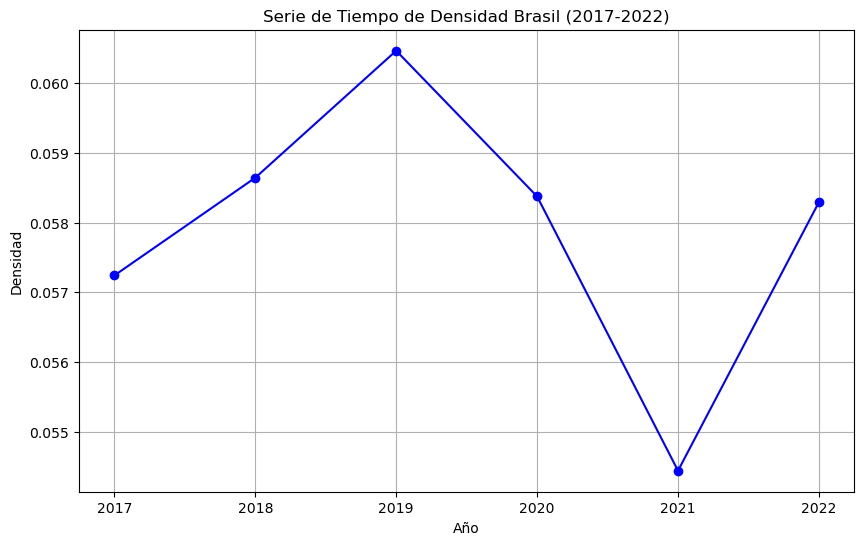

In [19]:
densidad_anio = [densidad2017, densidad2018, densidad2019, densidad2020, densidad2021, densidad2022]

df_densidad = pd.DataFrame({
    "Año": anios,
    "Densidad": densidad_anio})
df_densidad

df_densidad.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_densidad.index, df_densidad['Densidad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Densidad')
plt.title('Serie de Tiempo de Densidad Brasil (2017-2022)')
plt.grid(True)
plt.show()

### Centralización

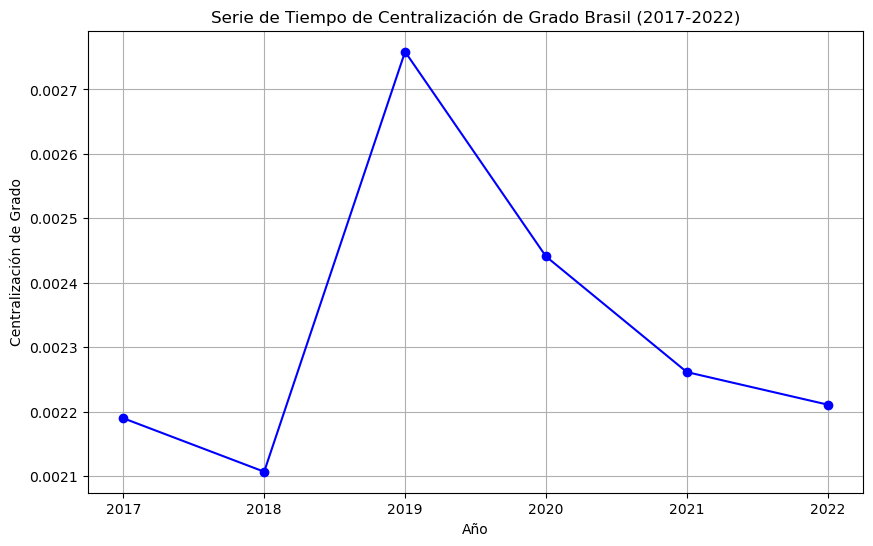

In [20]:
centralizacion_anio = [centralizacion2017, centralizacion2018, centralizacion2019, centralizacion2020, centralizacion2021, centralizacion2022]

df_centralizacion = pd.DataFrame({
    'Año': anios,
    'Centralización de Grado': centralizacion_anio})
df_centralizacion

df_centralizacion.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_centralizacion.index, df_centralizacion['Centralización de Grado'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Centralización de Grado')
plt.title('Serie de Tiempo de Centralización de Grado Brasil (2017-2022)')
plt.grid(True)
plt.show()

### Asortatividad

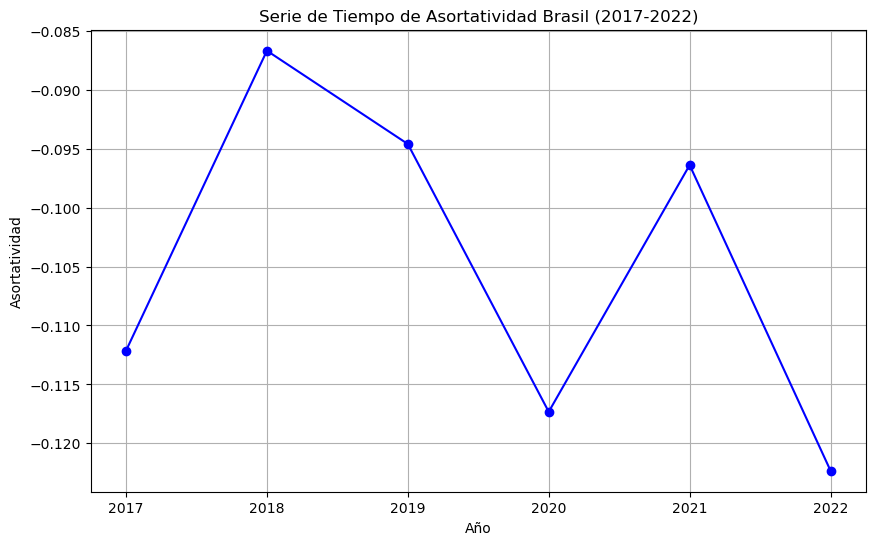

In [21]:
asort_anio = [asort2017, asort2018, asort2019, asort2020, asort2021, asort2022]

df_asort = pd.DataFrame({
    'Año': anios,
    'Asortatividad': asort_anio})

df_asort.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_asort.index, df_asort['Asortatividad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Asortatividad')
plt.title('Serie de Tiempo de Asortatividad Brasil (2017-2022)')
plt.grid(True)
plt.show()

### Transitividad

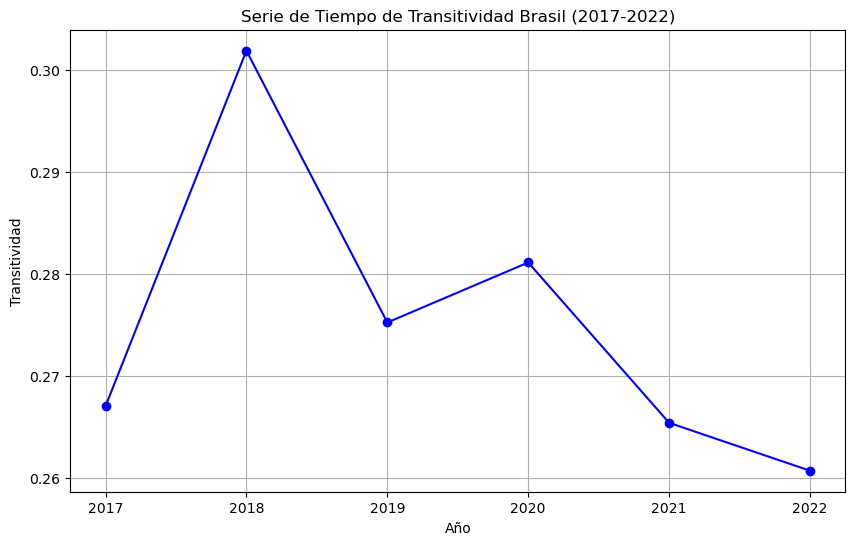

In [22]:
trans_anio = [trans2017, trans2018, trans2019, trans2020, trans2021, trans2022]

df_asort = pd.DataFrame({
    'Año': anios,
    'Transitividad': trans_anio})

df_asort.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_asort.index, df_asort['Transitividad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Transitividad')
plt.title('Serie de Tiempo de Transitividad Brasil (2017-2022)')
plt.grid(True)
plt.show()

### Comparación métricas


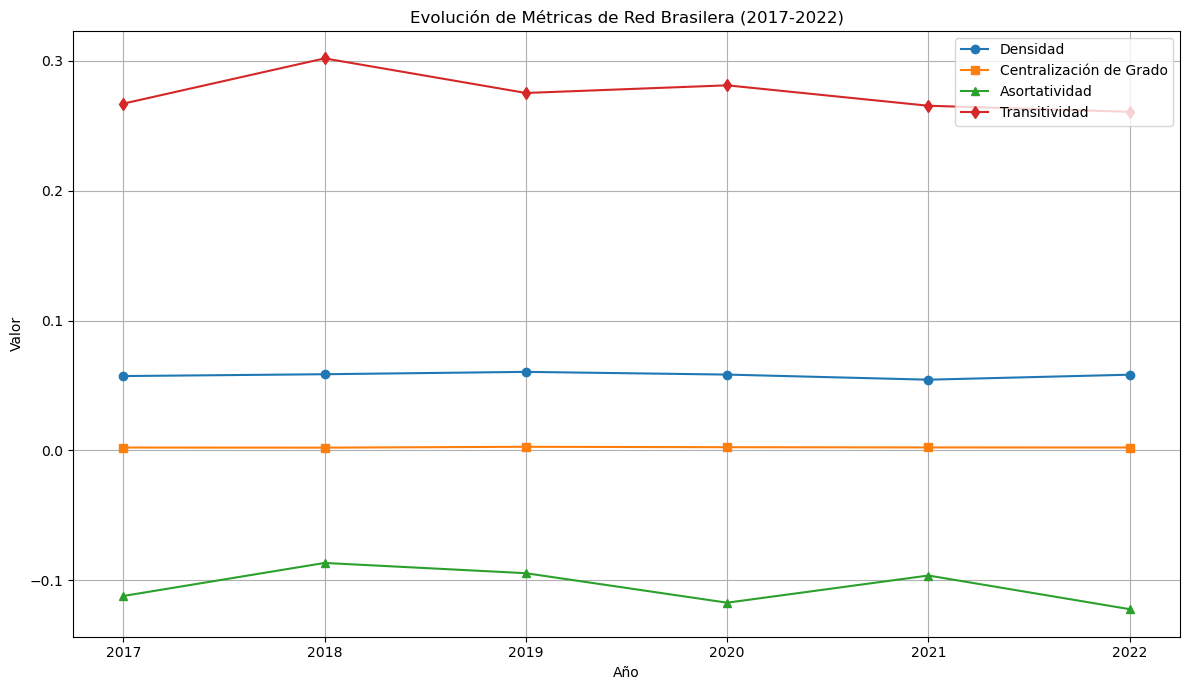

In [23]:
df = pd.DataFrame({
    'Año': anios,
    'Densidad': densidad_anio,
    'Centralización de Grado': centralizacion_anio,
    'Asortatividad': asort_anio,
    'Transitividad': trans_anio
})

df.set_index('Año', inplace=True)

plt.figure(figsize=(12, 7))
plt.plot(df.index, df['Densidad'], marker='o', label='Densidad')
plt.plot(df.index, df['Centralización de Grado'], marker='s', label='Centralización de Grado')
plt.plot(df.index, df['Asortatividad'], marker='^', label='Asortatividad')
plt.plot(df.index, df['Transitividad'], marker='d', label='Transitividad')

plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Evolución de Métricas de Red Brasilera (2017-2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()